In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "pub-2020-exploratory-analysis"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from mesostat.metric.metric import MetricCalculator
from mesostat.utils.qt_helper import gui_fname, gui_fnames, gui_fpath
from mesostat.utils.hdf5_io import DataStorage

from lib.sych.data_fc_db_raw import DataFCDatabase
import lib.analysis.pid as pid

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/pub-2020-exploratory-analysis


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
# params['root_path_data'] = './'
params['root_path_data'] = '/media/alyosha/Data/TE_data/yarodata/sych_preprocessed'
# params['root_path_data'] = '/media/aleksejs/DataHDD/work/data/yaro/neuronal-raw-pooled'
# params['root_path_data'] = gui_fpath('h5path', './')

In [3]:
dataDB = DataFCDatabase(params)

Searching for data files
Extracting trial type names
Extracting data types


In [4]:
dataDB.mice

{'mvg_4', 'mvg_7', 'mvg_8', 'mvg_9'}

In [5]:
h5outname = 'sych_result_higher_order_df.h5'

In [6]:
mc = MetricCalculator(serial=False, verbose=False, nCore=4)

# TODO
    
Hypothesis - Chain inhibition should increase synergy
* Cpu -> iGP/GP/eGP -> VM/VL

Performance-depencence
* Session-wise changes of redundancy/synergy as function of performance
* Movement-correlations of synergy/redundancy
    - Lick
    - Integral movement

# Hypotheses

In [7]:
intervDict = {
    "TEX" : [3, 3.5],
    "REW" : [6, 6.5]
}

hypothesesDict = {
    # Feedforwards Prefrontal
    "H1_TEX"  : ("TEX", ['M1_l', 'S1_bf'], ['PrL', 'LO', 'VO', 'M2', 'Cg1']),
    "H1a_TEX" : ("TEX", ['S1_bf', 'S2'],   ['PrL', 'LO', 'VO', 'M2', 'Cg1']),
    "H1b_TEX" : ("TEX", ['M1_l', 'M2'],    ['PrL', 'LO', 'VO', 'Cg1']),  # Drop M2 because its a source

    # High order is Sensory/Motor Thalamus
    # Test if (M1, S1) has more synergy than (M1, M2) or (S1, S2)
    "H2_TEX"  : ("TEX", ['M1_l', 'S1_bf'], ['Po', 'VM']),
    "H2a_TEX" : ("TEX", ['S1_bf', 'S2'],   ['Po', 'VM']),
    "H2b_TEX" : ("TEX", ['M1_l', 'M2'],    ['Po', 'VM']),
    
    # Thalamus as source
    "H3_TEX"  : ("TEX", ['Po', 'VPM'],     ['S1_bf', 'S2']),
    
    # Motor Thalamus synchronization
    "H4_TEX"  : ("TEX", ['VM', 'VL', 'LDVL'],      ['M1_l', 'M2']),
}

In [ ]:
pid.hypotheses_calc_pid(dataDB, mc, hypothesesDict, intervDict, h5outname, #nDropPCA=1,
                        datatypes=['bn_session', 'bn_trial'], trialType='iGO', performance='expert')

H1_TEX
(564, 48)
(1154, 48)
(1263, 48)


Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
  File "/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/multiprocess/queues.py", line 358, in get
    with self._rlock:
  File "/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/multiprocess

In [ ]:
pid.hypotheses_plot_pid(dataDB, hypothesesDict, h5outname, datatypes=['bn_session'])

In [ ]:
pid.hypotheses_calc_plot_info3D(dataDB, hypothesesDict, intervDict,
                                nBin=4, datatypes=['bn_session'], trialType='iGO', performance='expert')

# All-Distribution

**TODO**:
* [] Drop shitty sessions
* [] Try composite p-values
* [+] For Info3D, drop PCA1
* [] Consider re-doing analysis with PCA1 dropped
* Fraction Significant triplets per session
    * [+] Do regression on PID instead of Naive vs Expert
    * [ ] Binomial test fraction significant PID's above chance
    * [ ] Test if regression explained by having more iGO trials in expert
* Most significant triplets
    * [ ] Plot pvalue vs performance for top10 sessions

In [7]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
pwdAllH5 = '/media/alyosha/Data/TE_data/yarodata/sych_preprocessed/sych_result_multiregional_pid_df3.h5'
# pwdAllH5 = '/media/aleksejs/DataHDD/work/data/yaro/pid/sych_result_multiregional_pid_df3.h5'
# pwdAllH5 = gui_fname('h5path', './', '(*.h5)')

In [ ]:
pid.plot_all_results_distribution(dataDB, pwdAllH5, plotstyle='cdf', minTrials=50)

In [ ]:
pid.plot_all_frac_significant_bysession(dataDB, pwdAllH5, minTrials=50)

In [ ]:
# TODO: Linear fit + pval(H0: alpha=0)
pid.plot_all_frac_significant_performance_scatter(dataDB, pwdAllH5, minTrials=50)

TODO:
* Top 10 most synergetic connections
    - Try magnitude vs avg p-value vs fraction significant
    - Plot colorbars to show fraction of sessions by mouse
* Top 10 most synergy-involved regions
    - Count fraction of significant triplets where this region is target

In [8]:
summaryDF = pid.pid_all_summary_df(pwdAllH5)

In [9]:
# Precompute fraction of significant sessions for each triplet
pidTypes = ['unique', 'red', 'syn']
mouseSignDict = {}
for keyLabel, dfSession in summaryDF.groupby(['datatype', 'phase']):
    print(keyLabel)
    mouseSignDict[keyLabel] = pid._get_pid_sign_dict(dataDB, keyLabel,
                                                     dfSession.drop(['datatype', 'phase'], axis=1),
                                                     pwdAllH5, pidTypes, minTrials=50, trialType='iGO')

('bn_session', 'REW')
('bn_session', 'REW') mvg_4
('bn_session', 'REW') mvg_7
Skipping session mvg_7_2018_11_09_a because it has too few trials 3
Skipping session mvg_7_2018_11_12_a because it has too few trials 13
Skipping session mvg_7_2018_11_13_a because it has too few trials 13
('bn_session', 'REW') mvg_8
Skipping session mvg_8_2018_11_12_a because it has too few trials 44
Skipping session mvg_8_2018_11_13_a because it has too few trials 41
Skipping session mvg_8_2018_11_18_a because it has too few trials 38
('bn_session', 'REW') mvg_9
Skipping session mvg_9_2019_02_06_a because it has too few trials 39
Skipping session mvg_9_2019_02_08_a because it has too few trials 15
Skipping session mvg_9_2019_02_12_a because it has too few trials 16
('bn_session', 'TEX')
('bn_session', 'TEX') mvg_4
('bn_session', 'TEX') mvg_7
Skipping session mvg_7_2018_11_09_a because it has too few trials 3
Skipping session mvg_7_2018_11_12_a because it has too few trials 13
Skipping session mvg_7_2018_11_

In [10]:
# 1D projection: Targets that have highest fraction of sessions averaged over sources
for keyLabel, dfSession in summaryDF.groupby(['datatype', 'phase']):
    print(keyLabel)
    
    pid.plot_all_frac_significant_1D_top_n(dataDB, mouseSignDict[keyLabel], '_'.join(keyLabel), pidTypes, nTop=20)

('bn_session', 'REW')
unique mvg_9 90560 2162.0
unique mvg_8 81464 2162.0
unique mvg_7 80655 2162.0
unique mvg_4 82127 2162.0
red mvg_9 51888 1081.0
red mvg_8 51391 1081.0
red mvg_7 51293 1081.0
red mvg_4 51217 1081.0
syn mvg_9 25484 1081.0
syn mvg_8 15664 1081.0
syn mvg_7 24267 1081.0
syn mvg_4 24486 1081.0
('bn_session', 'TEX')
unique mvg_9 87566 2162.0
unique mvg_8 87028 2162.0
unique mvg_7 80523 2162.0
unique mvg_4 86282 2162.0
red mvg_9 51888 1081.0
red mvg_8 51594 1081.0
red mvg_7 51566 1081.0
red mvg_4 51537 1081.0
syn mvg_9 26659 1081.0
syn mvg_8 16546 1081.0
syn mvg_7 25353 1081.0
syn mvg_4 25769 1081.0
('bn_trial', 'REW')
unique mvg_9 83294 2162.0
unique mvg_8 82676 2162.0
unique mvg_7 81356 2162.0
unique mvg_4 82379 2162.0
red mvg_9 51725 1081.0
red mvg_8 51729 1081.0
red mvg_7 51783 1081.0
red mvg_4 51534 1081.0
syn mvg_9 25618 1081.0
syn mvg_8 16687 1081.0
syn mvg_7 26066 1081.0
syn mvg_4 26147 1081.0
('bn_trial', 'TEX')
unique mvg_9 82906 2162.0
unique mvg_8 88690 2162.0


In [13]:
# 2D projection: Source pairs that have highest fraction of sessions averaged over targets
for keyLabel, dfSession in summaryDF.groupby(['datatype', 'phase']):
    print(keyLabel)
    pid.plot_all_frac_significant_2D_avg(dataDB, mouseSignDict[keyLabel], '_'.join(keyLabel), pidTypes)

('bn_session', 'REW')
0.6469126887605149
0.8571158913550218
0.1178570825309956
('bn_session', 'TEX')
0.6829224519441911
0.8911033411033411
0.12773048207830814
('bn_trial', 'REW')
0.7194702037093341
0.9110815512989426
0.14451032059727711
('bn_trial', 'TEX')
0.7326990642208034
0.9472146211276646
0.1797076112293504


In [ ]:
# 3D projection: Triplets with highest fraction of sessions
for keyLabel, dfSession in summaryDF.groupby(['datatype', 'phase']):
    print(keyLabel)
    pid.plot_all_frac_significant_3D_top_n(dataDB, mouseSignDict[keyLabel], '_'.join(keyLabel), pidTypes, nTop=20)

In [16]:
# Specific 2D projection: Fractions for all source pairs given target
for keyLabel, dfSession in summaryDF.groupby(['datatype', 'phase']):
    print(keyLabel)
    pid.plot_all_frac_significant_2D_by_target(dataDB, mouseSignDict[keyLabel], '_'.join(keyLabel), 'syn', 'VPL',
                                               vmax=1)

('bn_session', 'REW')
0.41750194250194256
('bn_session', 'TEX')
0.34127816627816626
('bn_trial', 'REW')
0.370998445998446
('bn_trial', 'TEX')
0.4228438228438229


In [14]:
hDict = {
#     "H_ALL"  : ("REW", ['VPL', 'DG_a'], ['VM'])
    "H_ALL"  : ("REW", ['Rt', 'SuG'], ['Cpu'])
#     "H_ALL"  : ("REW", ['Cpu_1', 'VPL'], ['VL'])
#         "H_ALL"  : ("TEX", ['M2', 'S2'], ['VPL'])
}

pid.hypotheses_calc_plot_info3D(dataDB, hDict, intervDict, #performance='expert',
                                datatypes=['bn_session', 'bn_trial'], trialType='iGO')

H_ALL
H_ALL


## All - Distribution - Nosession

In [8]:
import lib.analysis.pid_joint as pid_joint

In [9]:
pwdAllH5_2 = '/media/alyosha/Data/TE_data/yarodata/sych_preprocessed/sych_result_multiregional_pid_all_df.h5'

In [10]:
dfSummary = pid_joint.pid_all_summary_df(pwdAllH5_2)

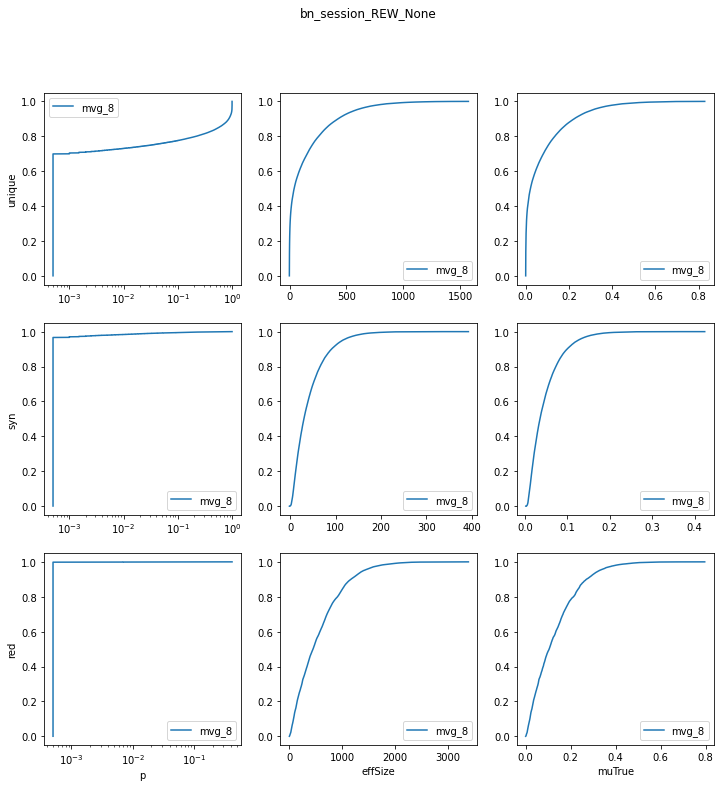

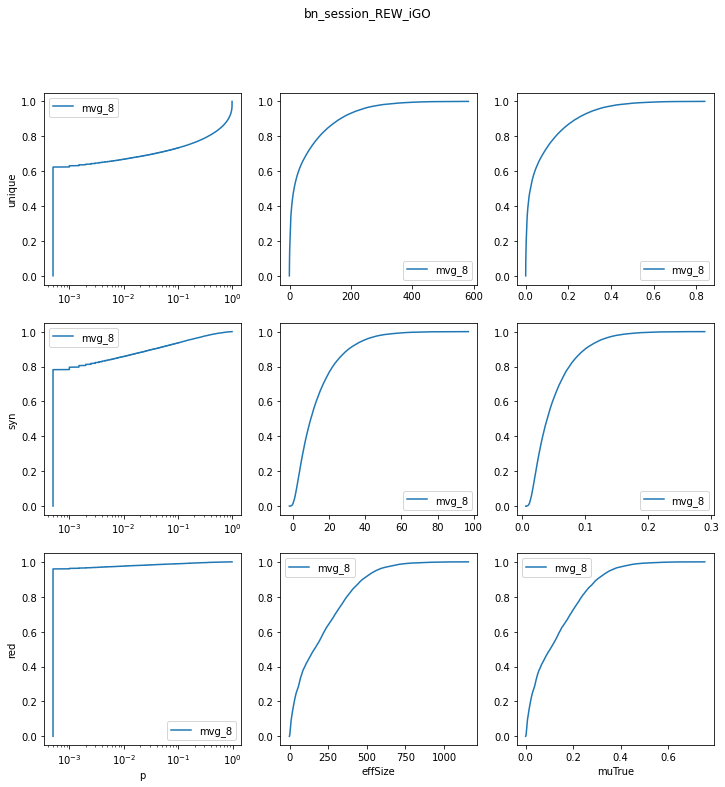

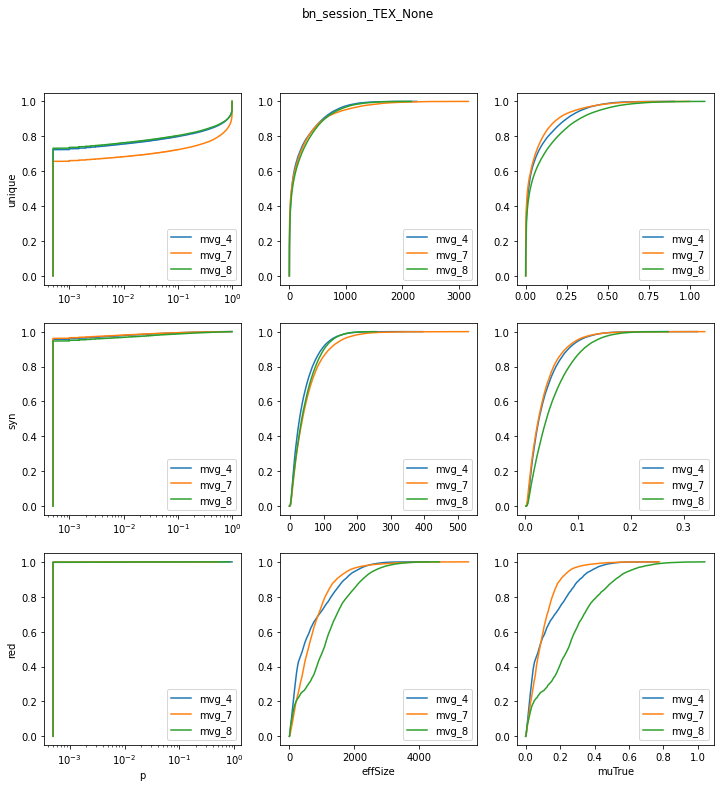

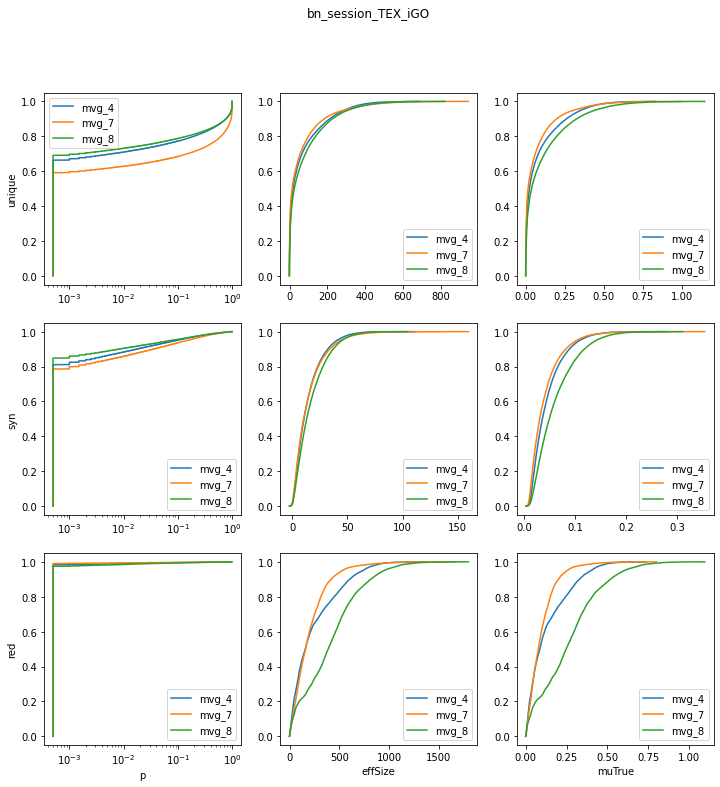

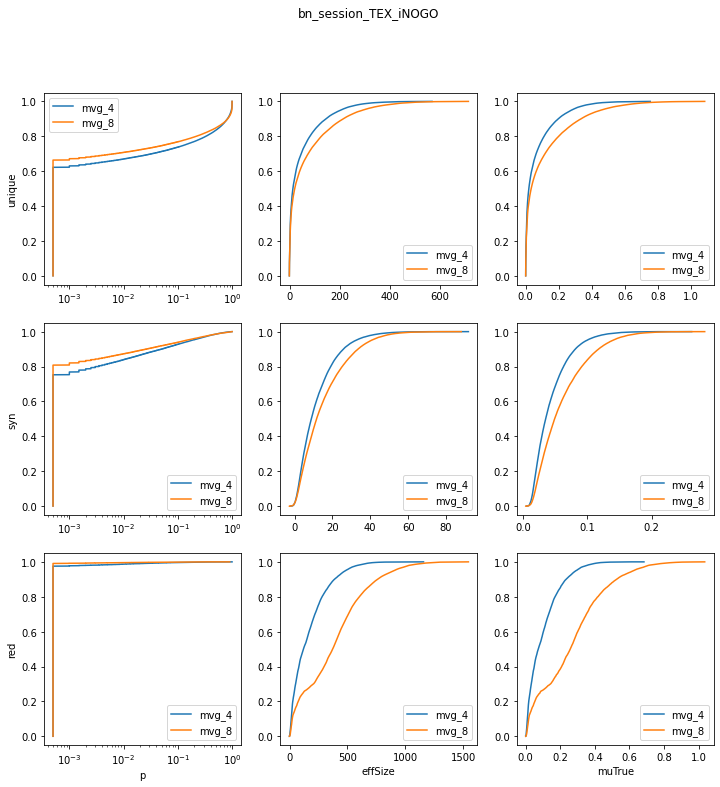

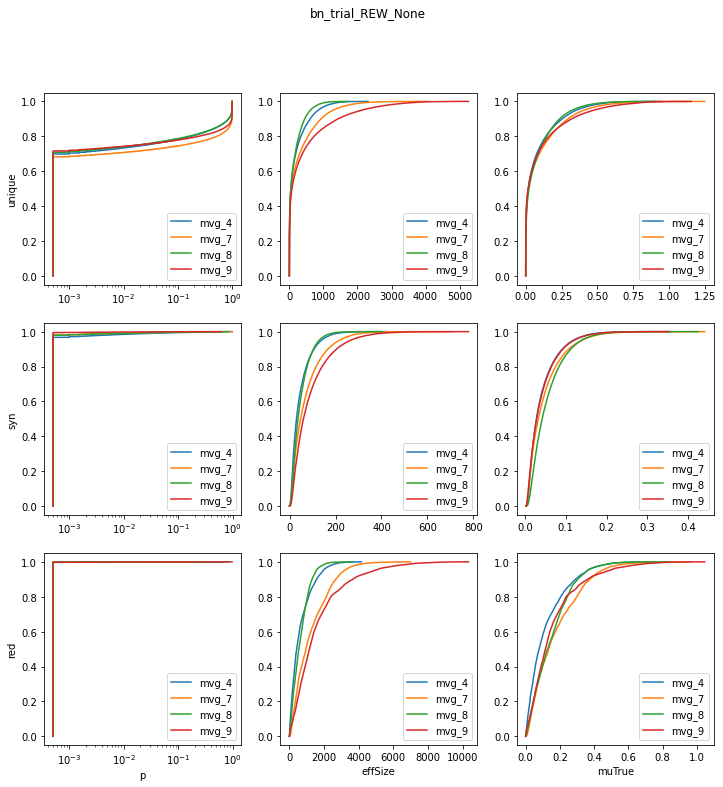

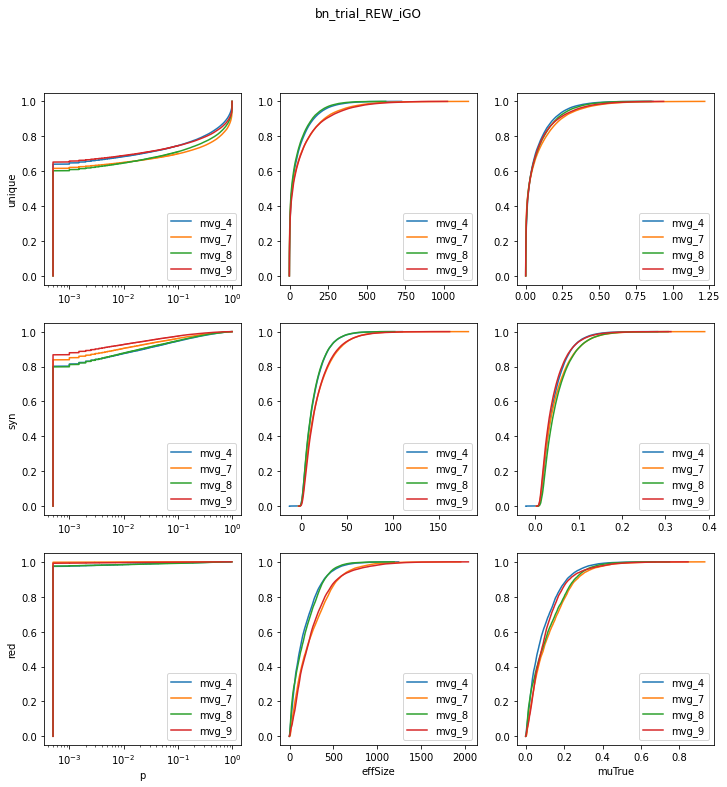

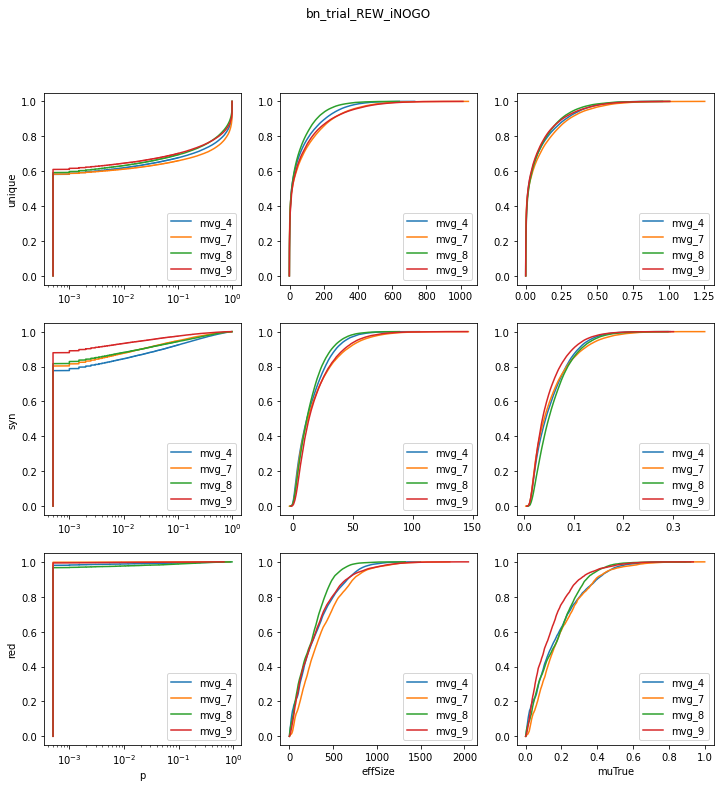

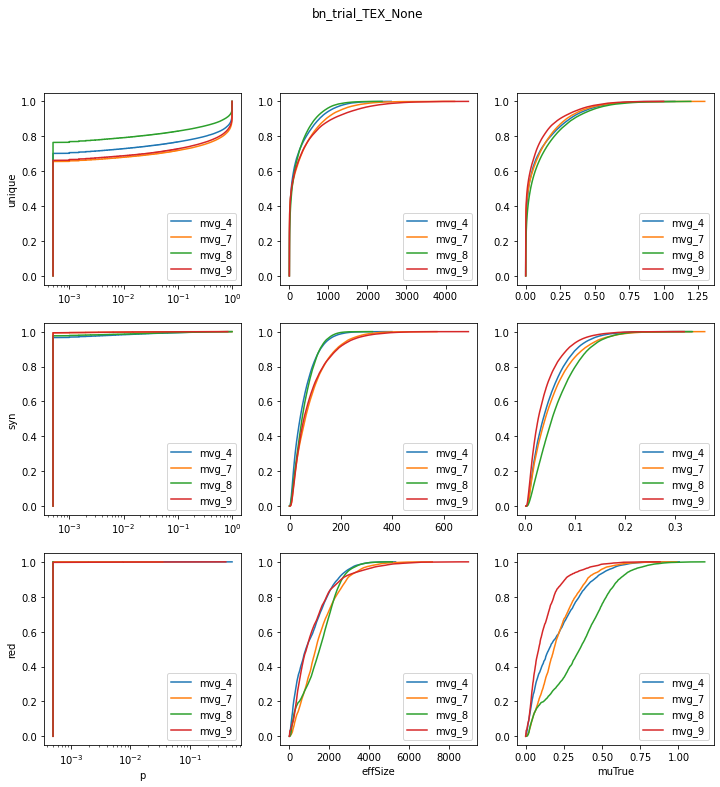

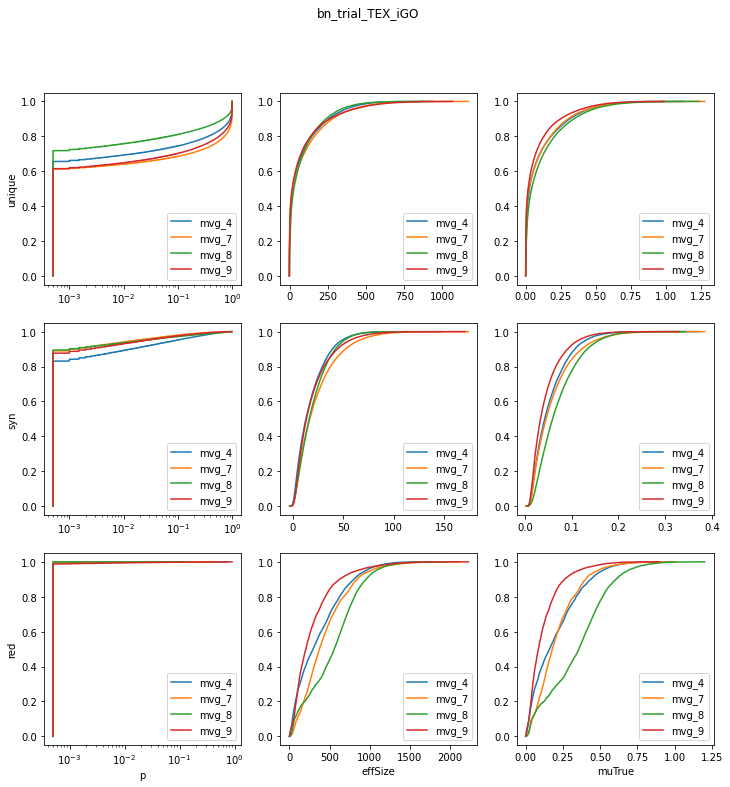

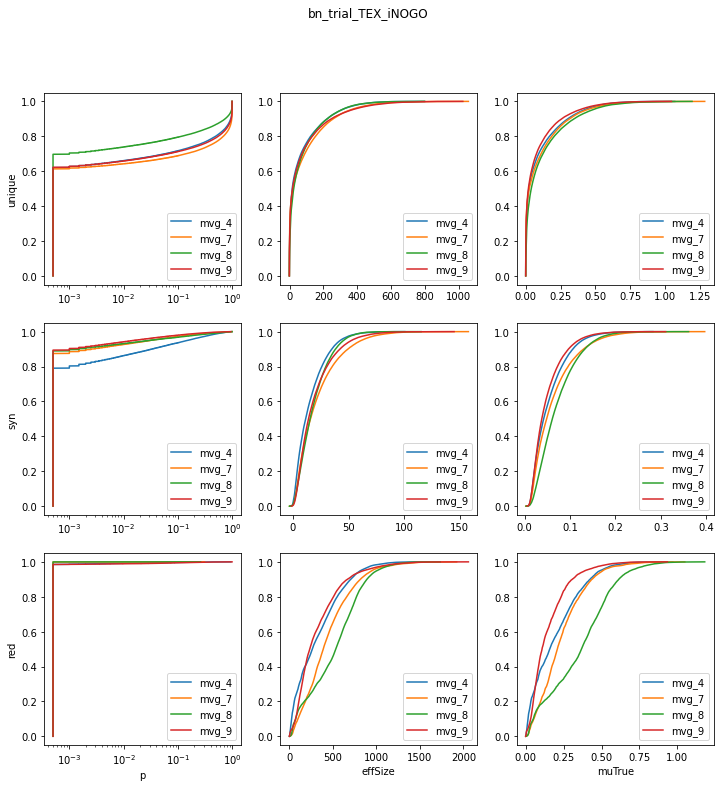

In [13]:
pid_joint.cdfplot(pwdAllH5_2, dfSummary)

('bn_session', 'REW', 'None')


IndexError: tuple index out of range

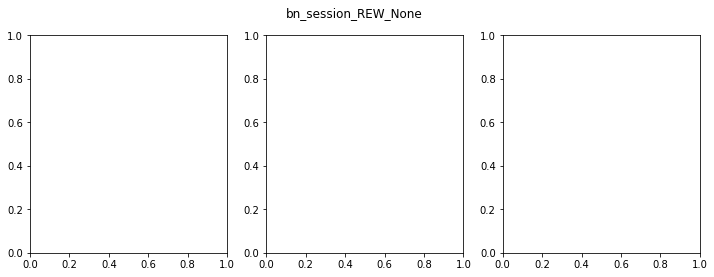

In [14]:
pid_joint.test_avg_bits(dataDB, mc, pwdAllH5_2, dfSummary)

In [ ]:
pid_joint.scatter_effsize_bits(pwdAllH5_2, dfSummary)

unique 103776 103776
syn 51888 51888
red 51888 51888


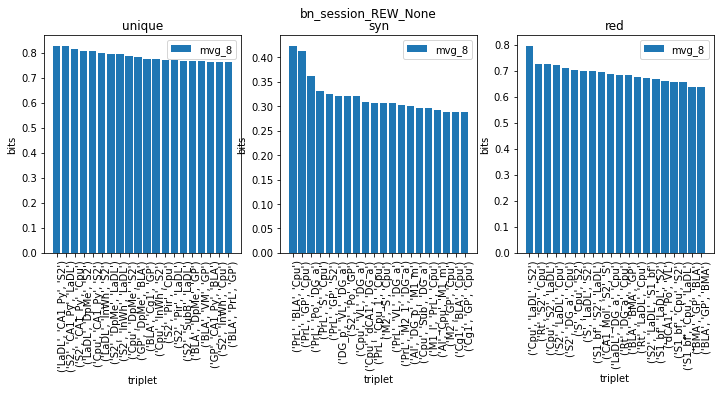

unique 103776 103776
syn 51888 51888
red 51888 51888


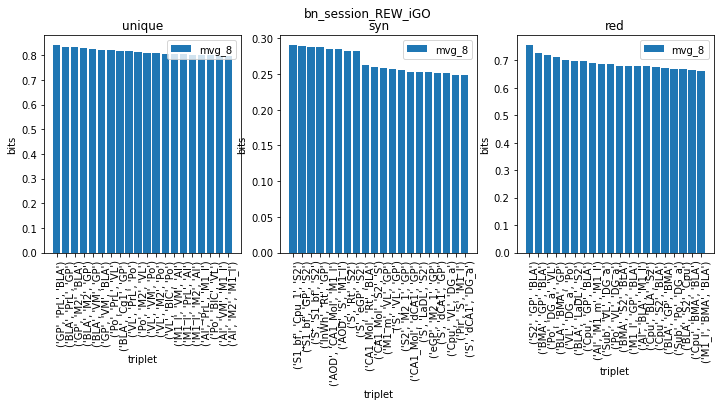

unique 103776 103776
syn 51888 51888
red 51888 51888


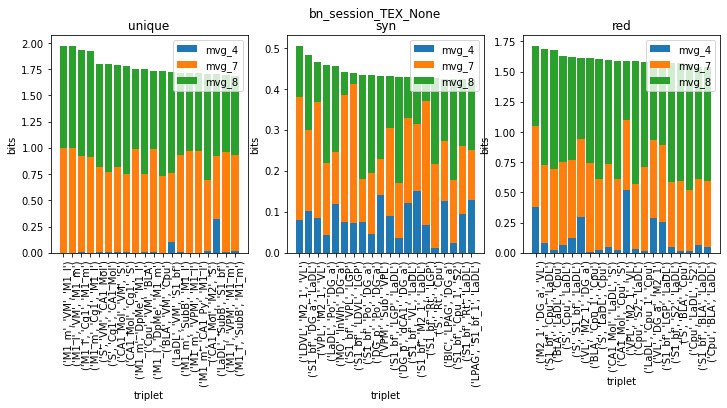

unique 103776 103776
syn 51888 51888
red 51888 51888


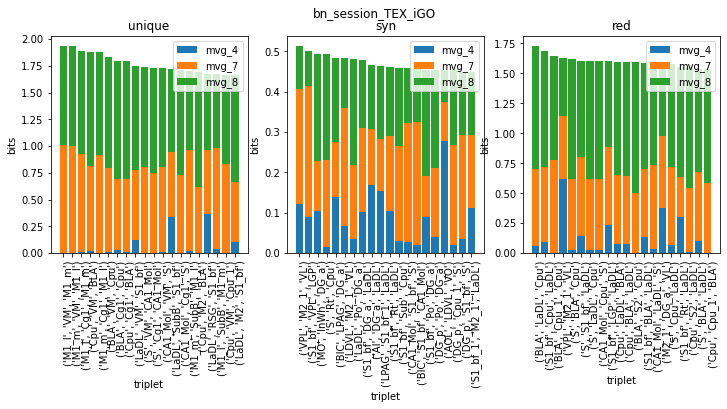

unique 103776 103776
syn 51888 51888
red 51888 51888


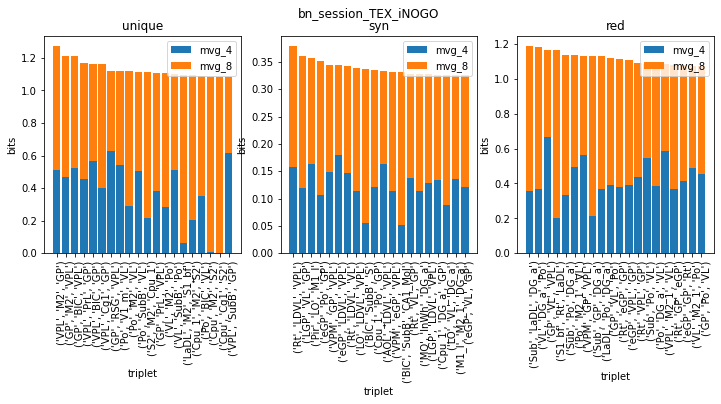

unique 103776 103776
syn 51888 51888
red 51888 51888


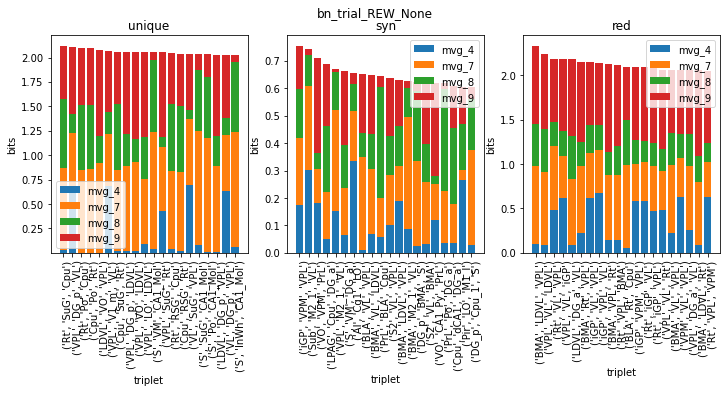

unique 103776 103776
syn 51888 51888
red 51888 51888


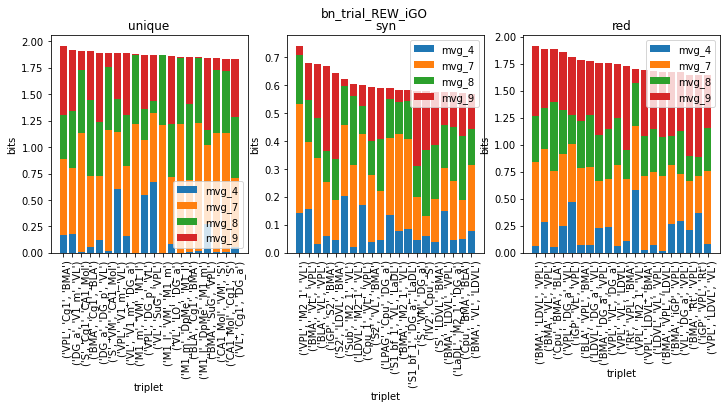

unique 103776 103776
syn 51888 51888
red 51888 51888


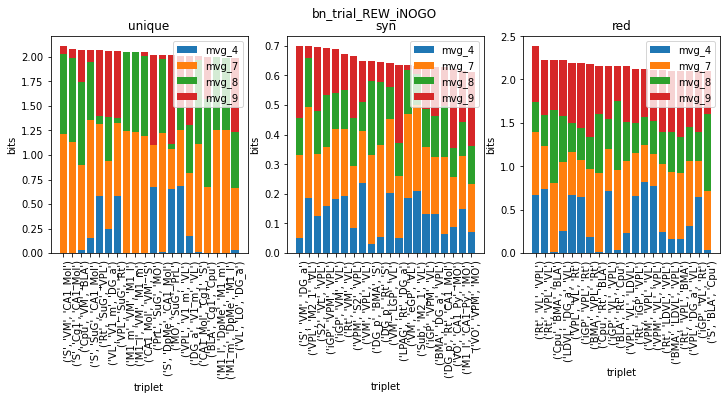

unique 103776 103776
syn 51888 51888
red 51888 51888


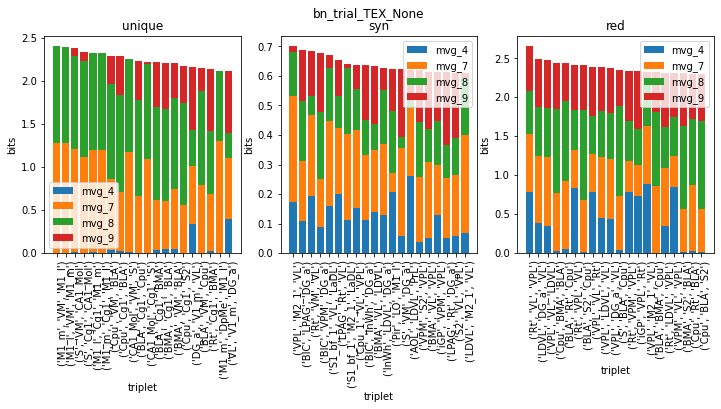

unique 103776 103776
syn 51888 51888
red 51888 51888


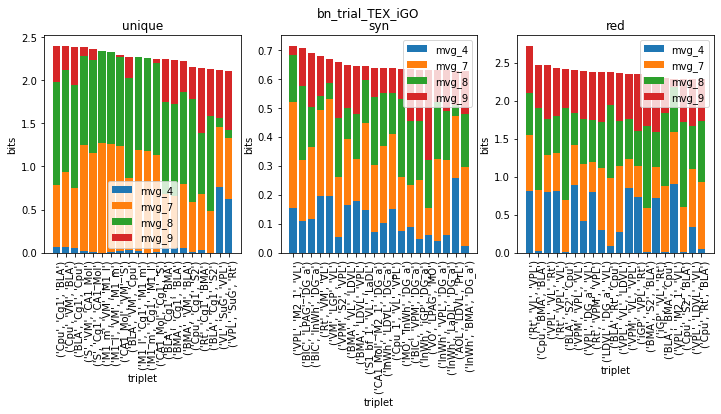

unique 103776 103776
syn 51888 51888
red 51888 51888


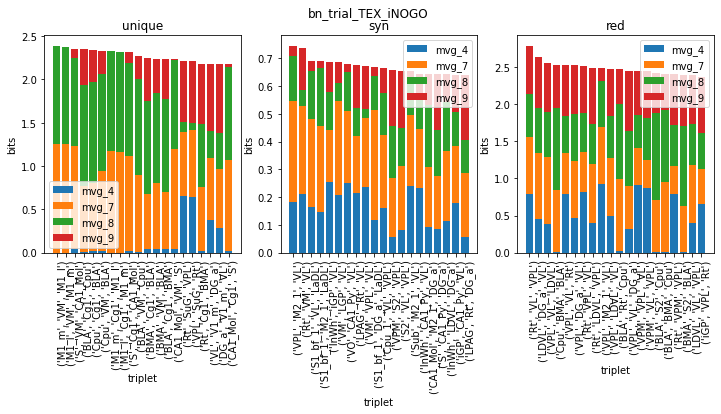

In [36]:
pid_joint.plot_triplets(pwdAllH5_2, dfSummary, nTop=20)

unique 103776 103776
syn 51888 51888
red 51888 51888


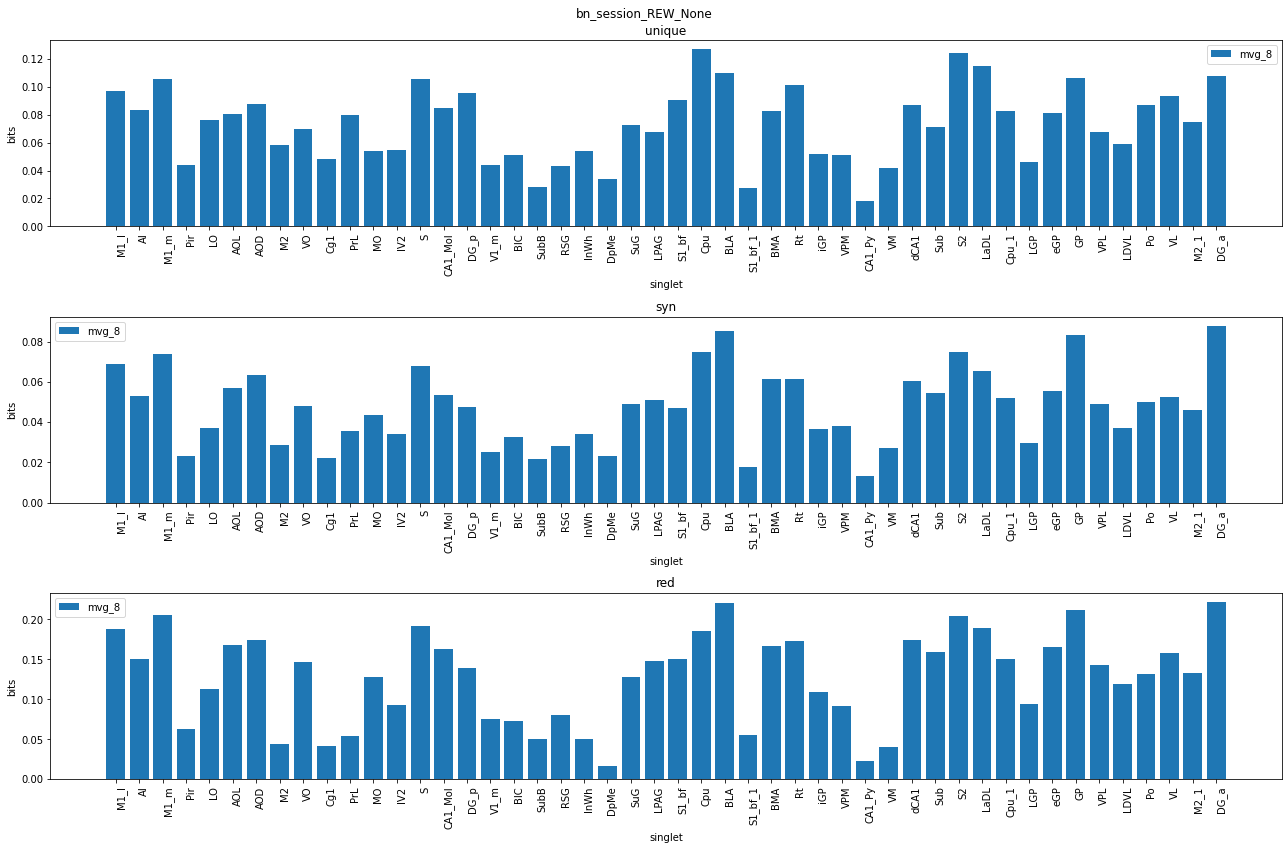

unique 103776 103776
syn 51888 51888
red 51888 51888


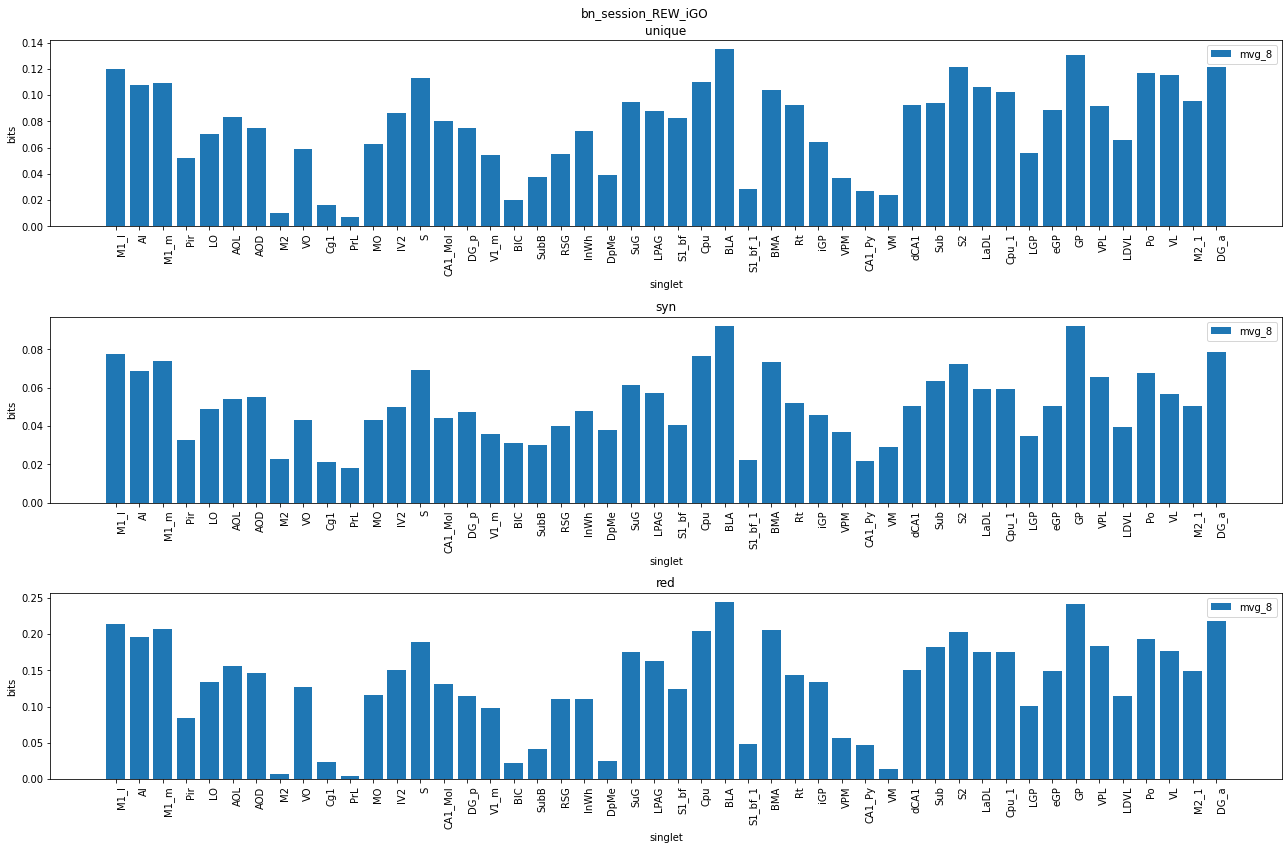

unique 103776 103776
syn 51888 51888
red 51888 51888


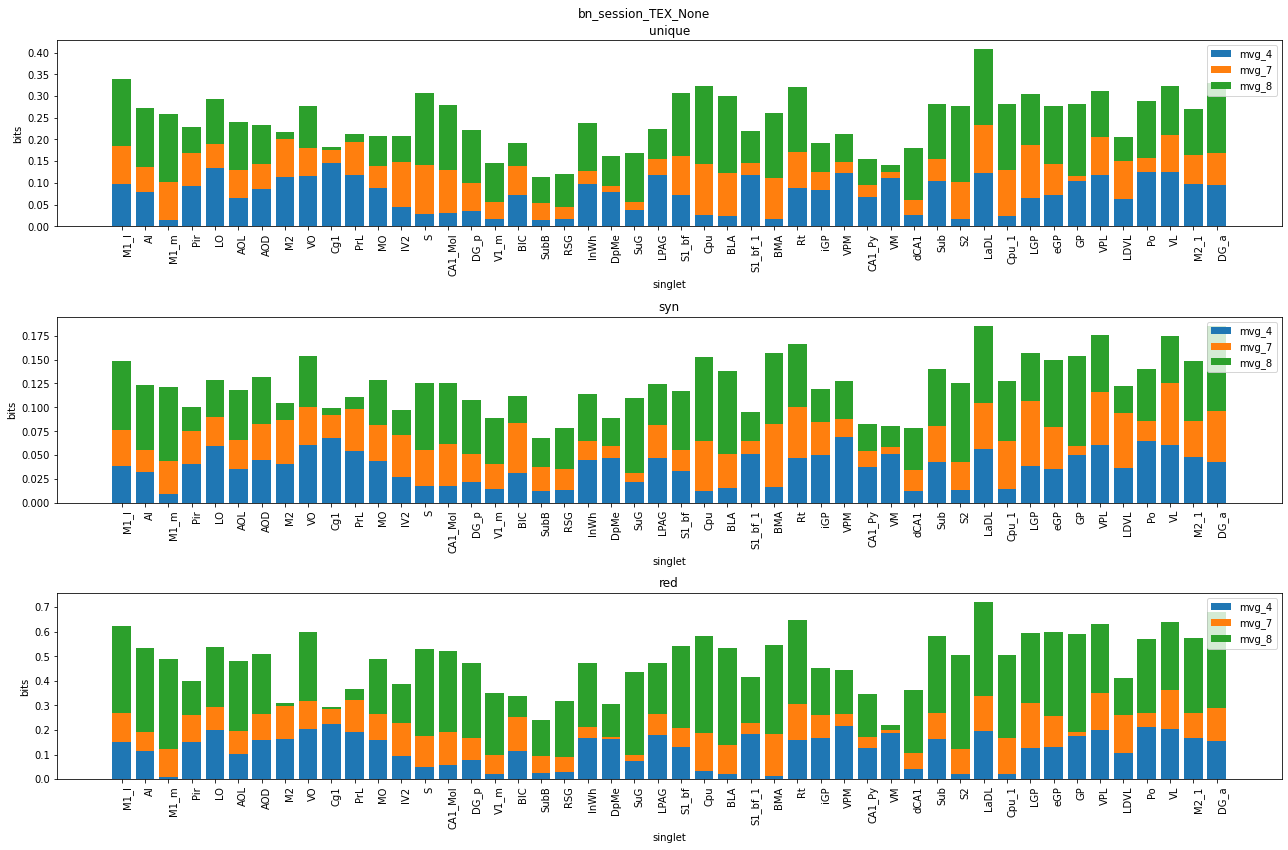

unique 103776 103776
syn 51888 51888
red 51888 51888


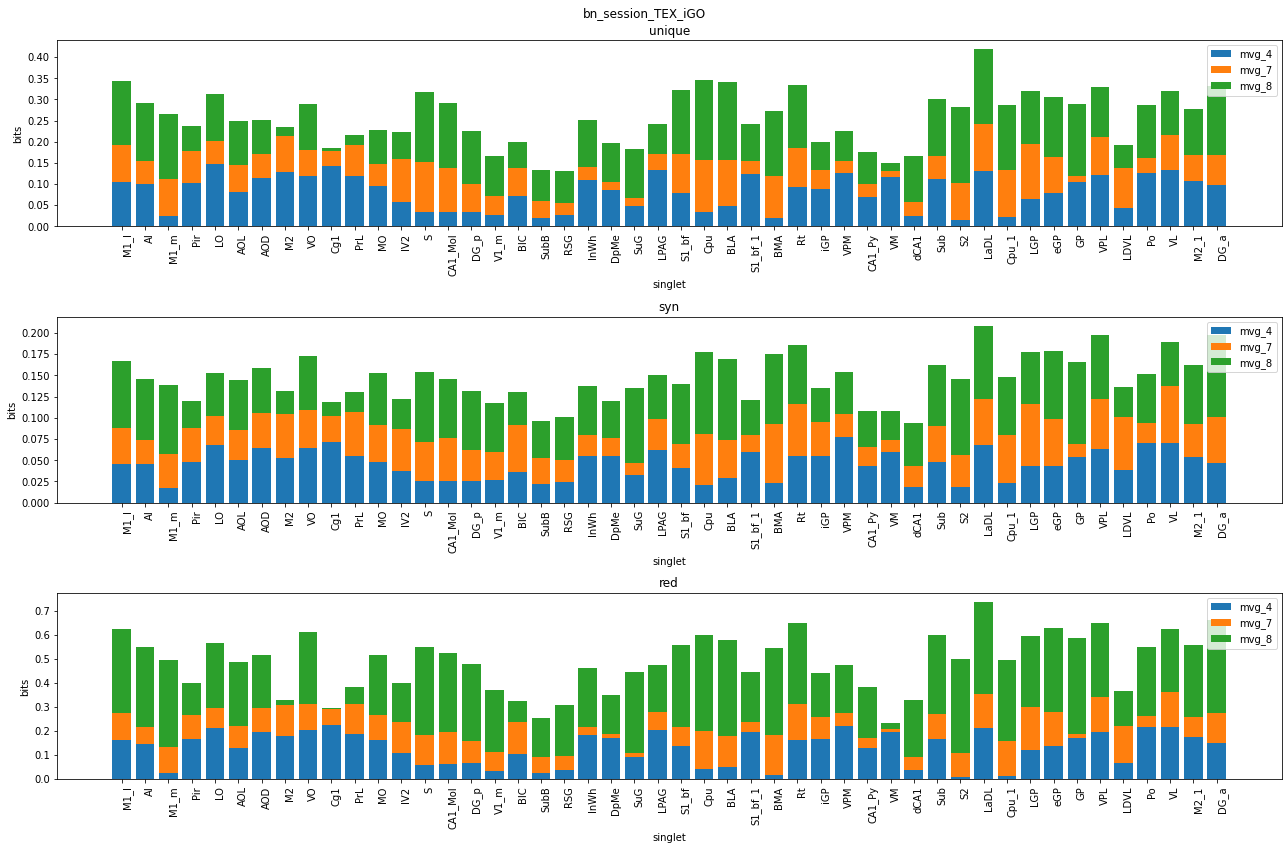

unique 103776 103776
syn 51888 51888
red 51888 51888


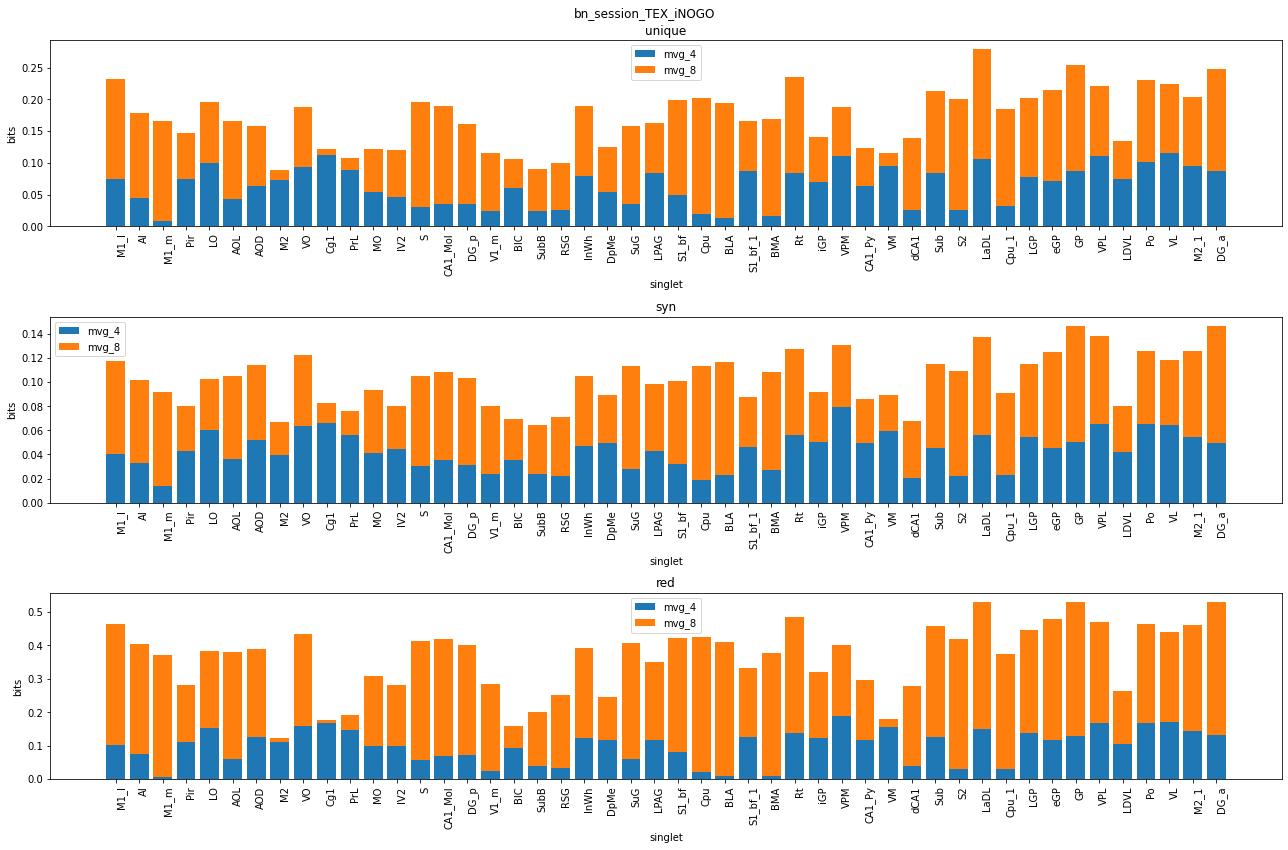

unique 103776 103776
syn 51888 51888
red 51888 51888


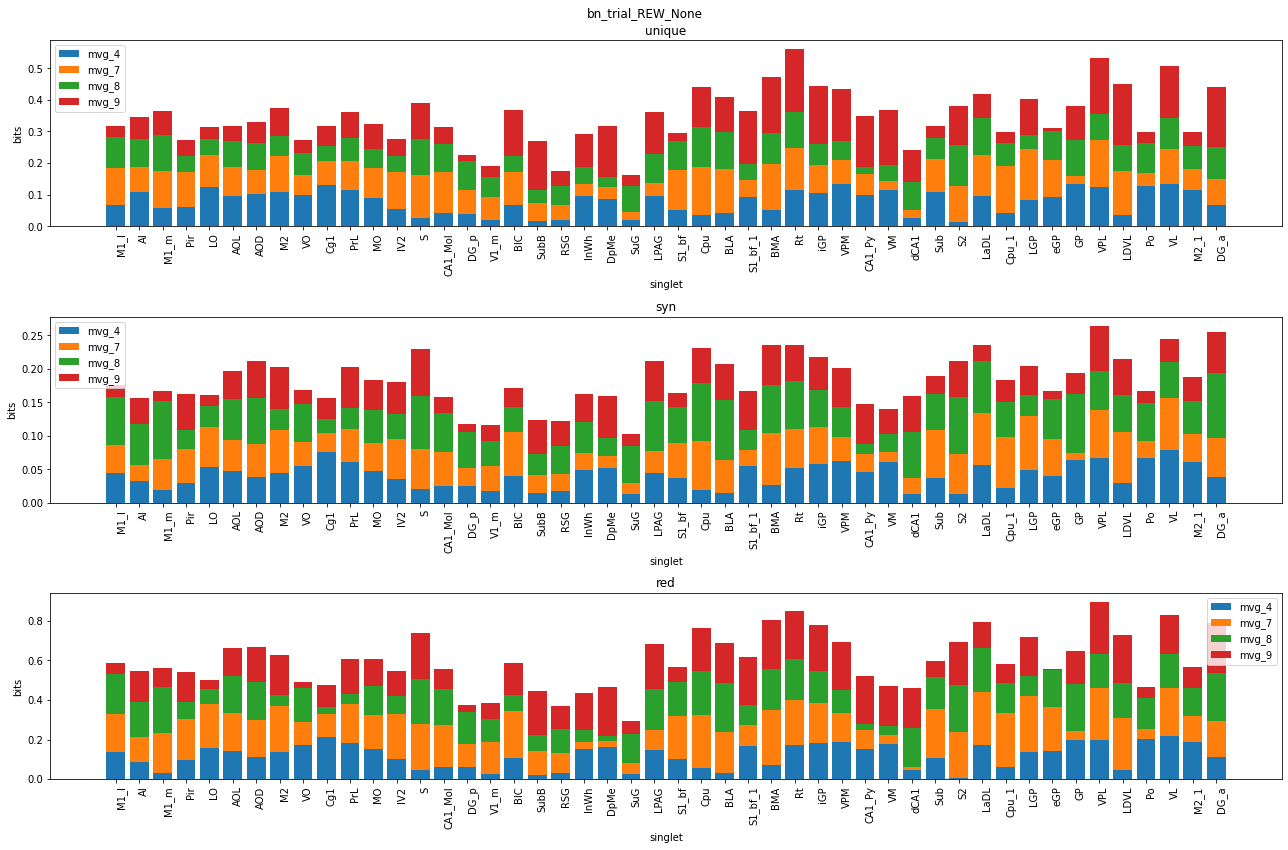

unique 103776 103776
syn 51888 51888
red 51888 51888


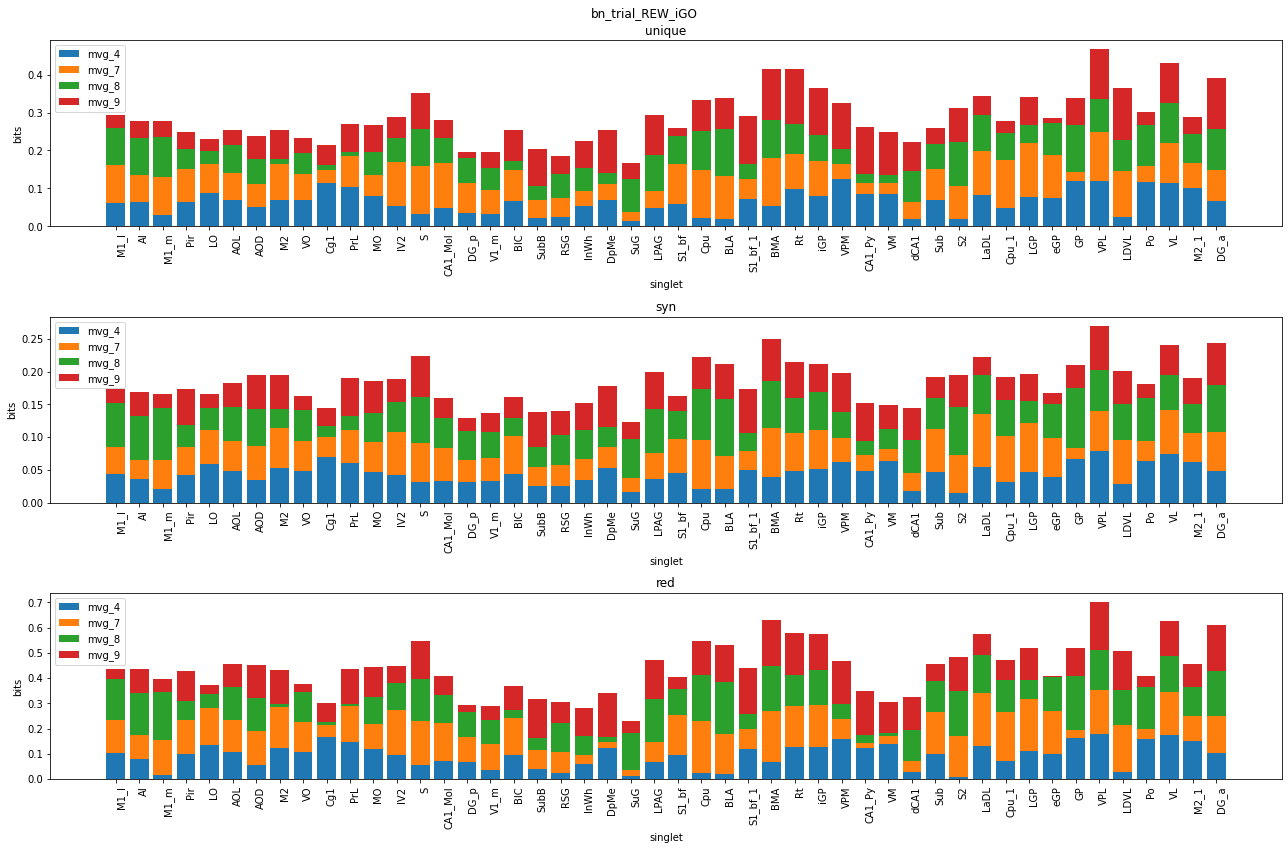

unique 103776 103776
syn 51888 51888
red 51888 51888


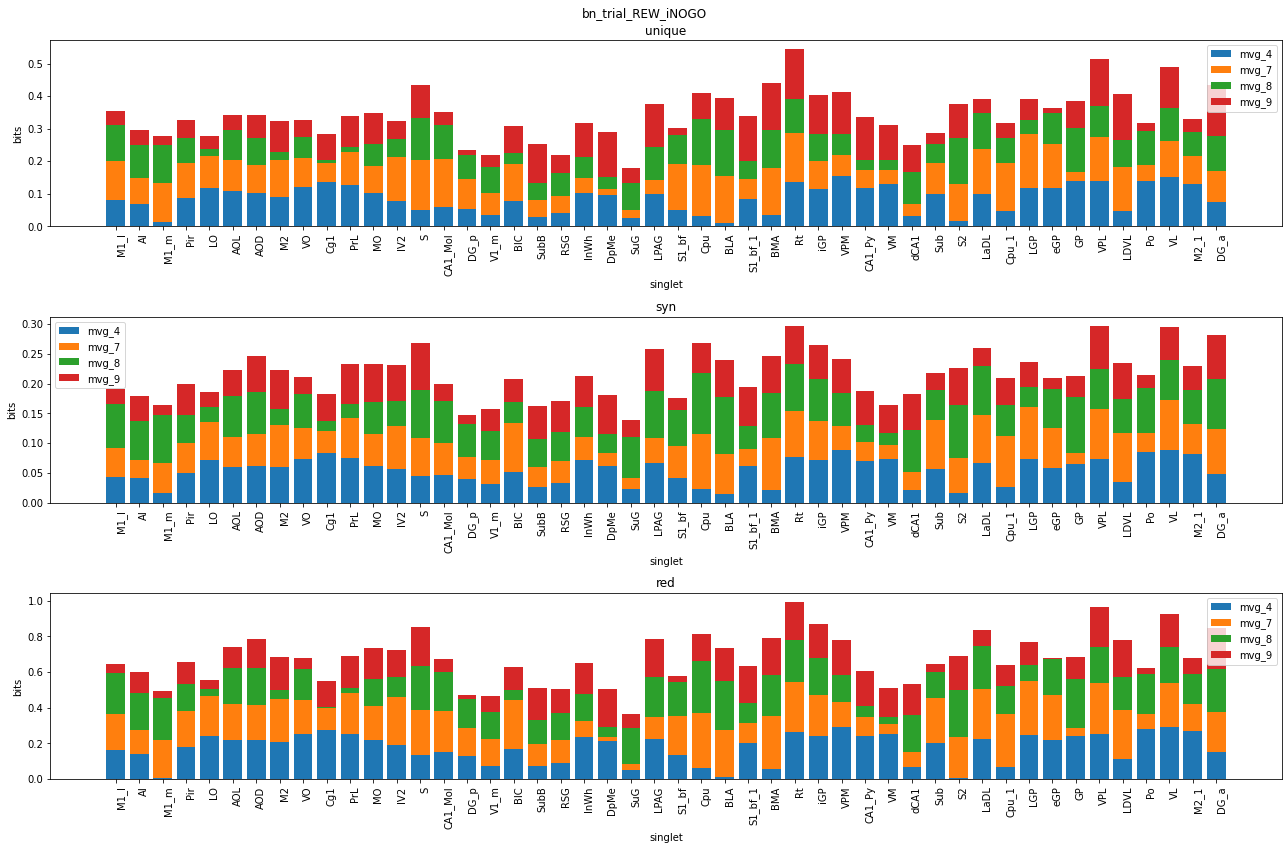

unique 103776 103776
syn 51888 51888
red 51888 51888


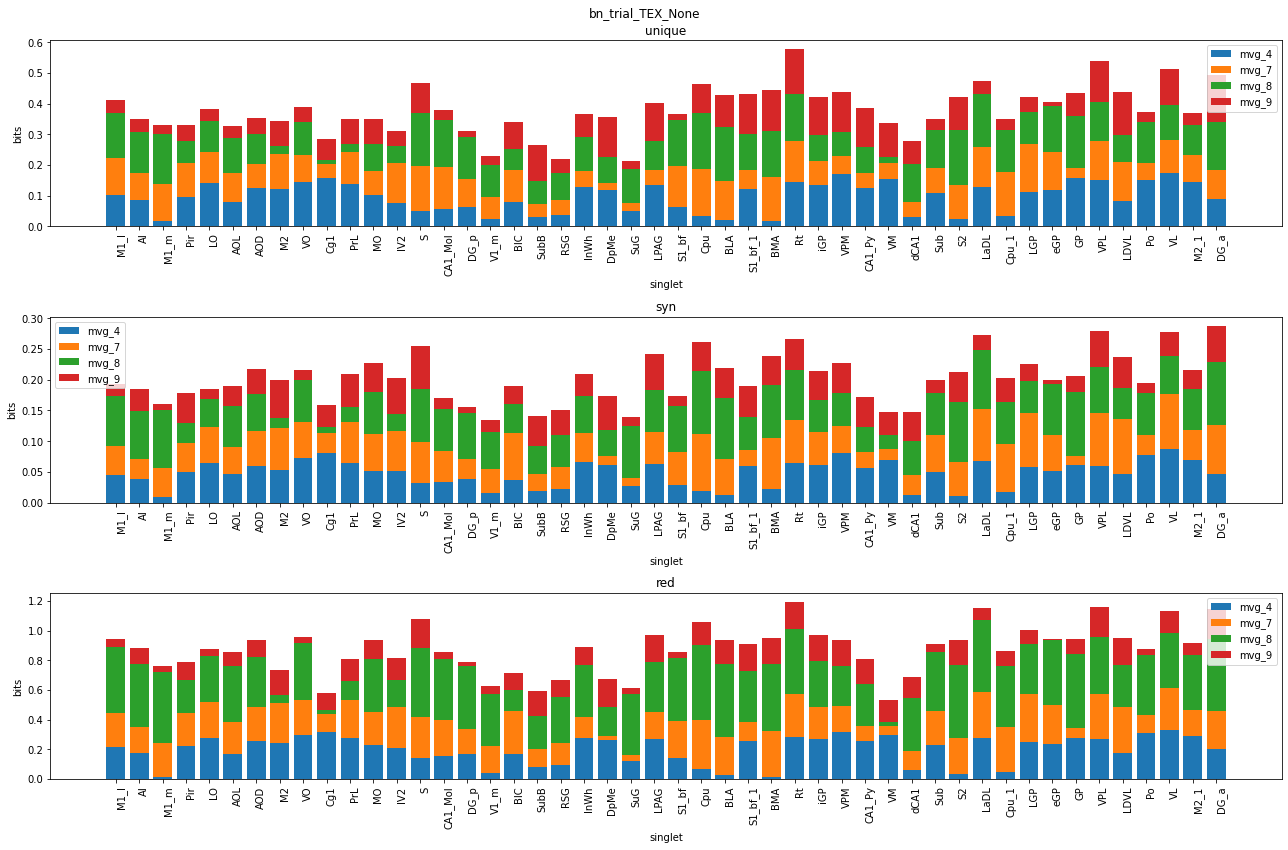

unique 103776 103776
syn 51888 51888
red 51888 51888


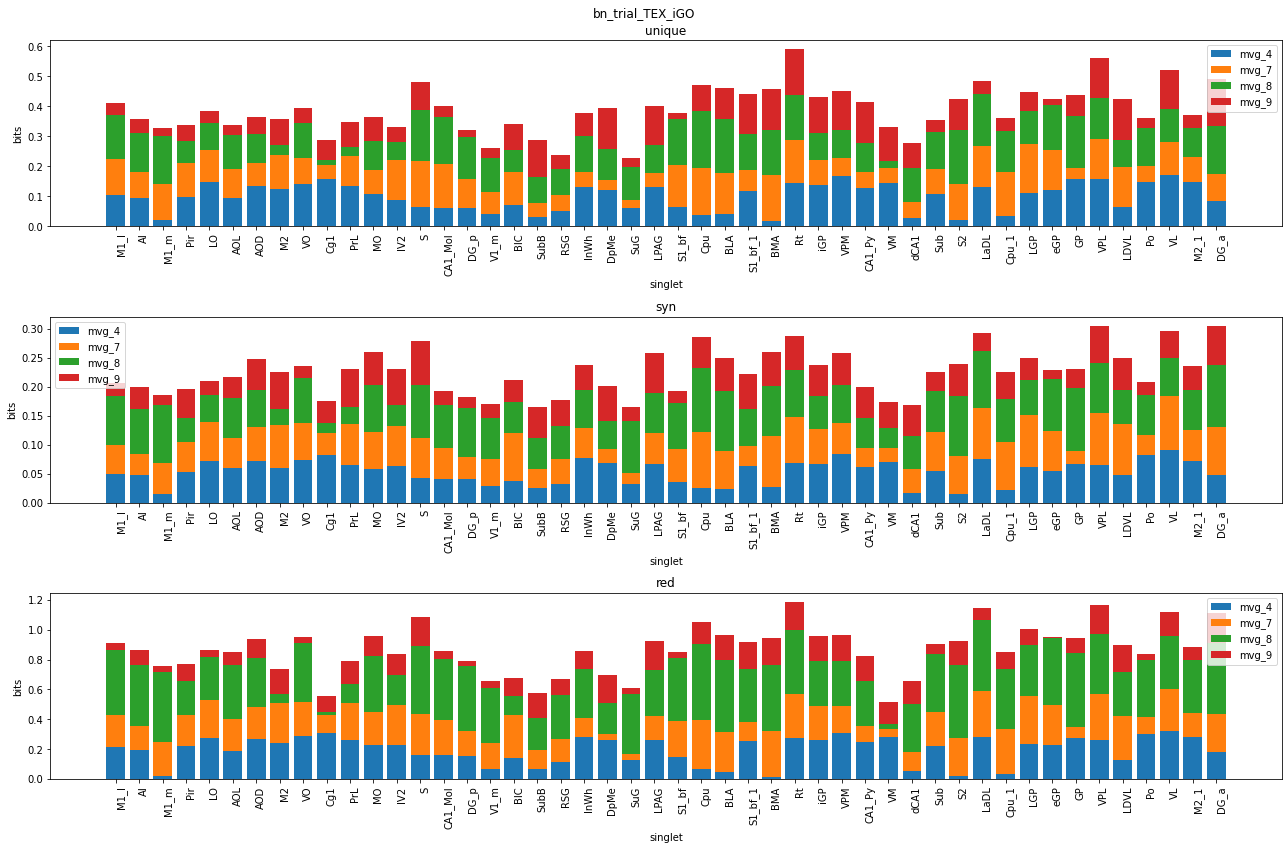

unique 103776 103776
syn 51888 51888
red 51888 51888


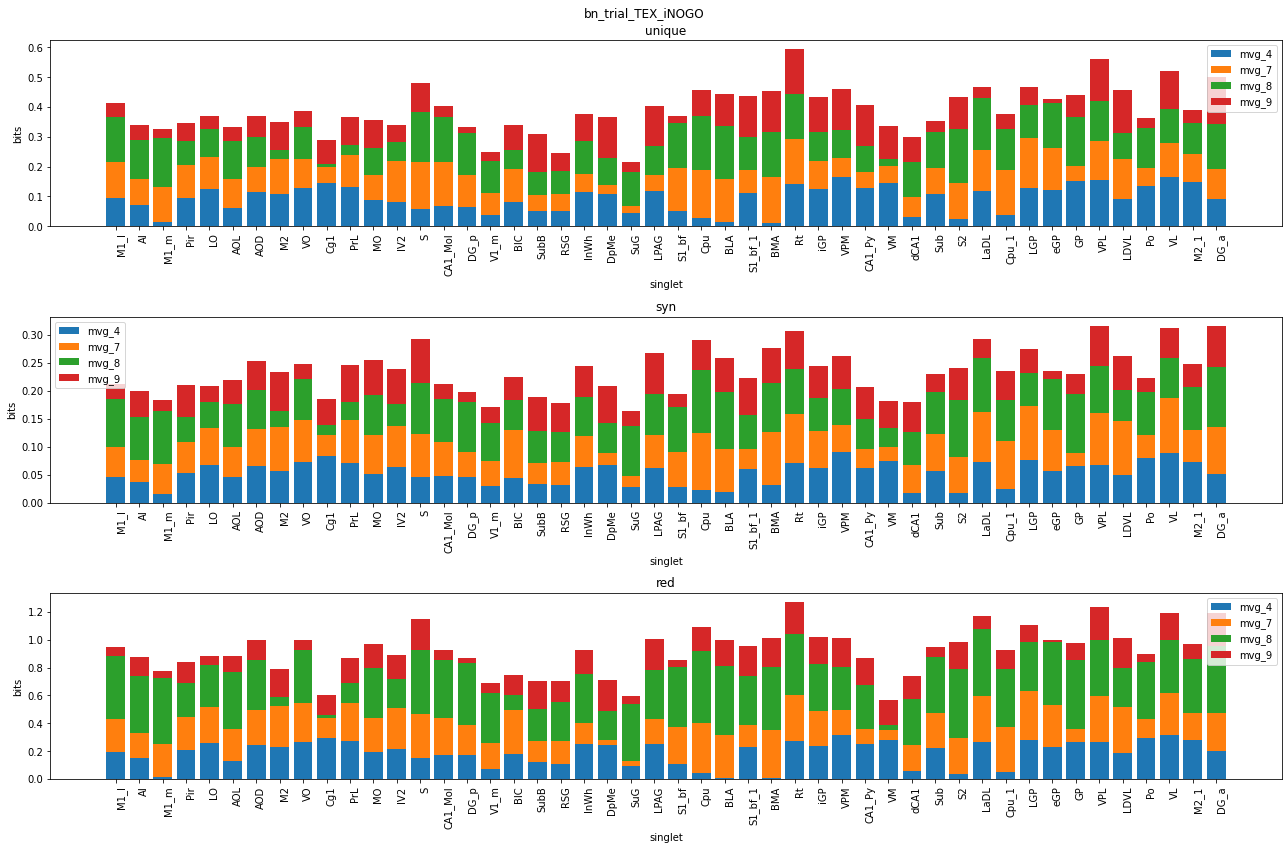

In [18]:
pid_joint.plot_singlets(dataDB, pwdAllH5_2, dfSummary, nTop=20)

unique 103776 103776
syn 51888 51888
red 51888 51888
0.29891199298009946
0.10067335153124646
0.28268565760340797


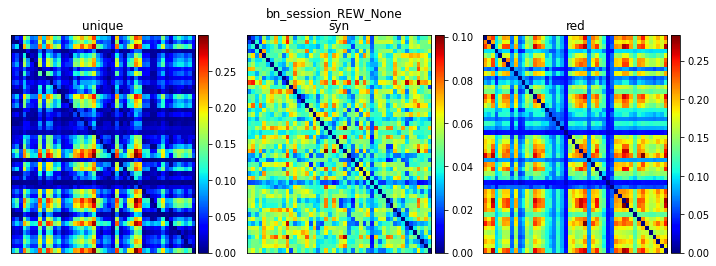

unique 103776 103776
syn 51888 51888
red 51888 51888
0.3780411014321952
0.11448951167951611
0.32925138021351824


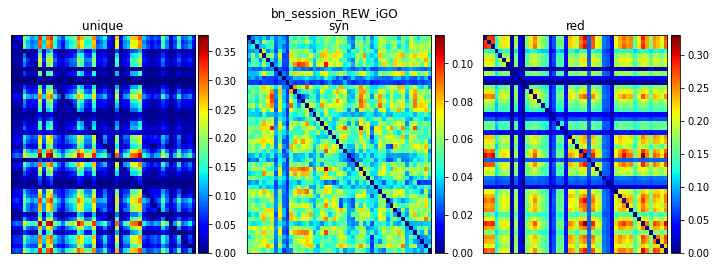

unique 103776 103776
syn 51888 51888
red 51888 51888
0.2734254238812268
0.07806203697115814
0.2937489948767739


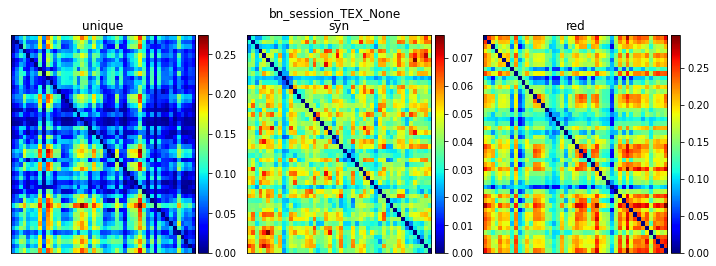

unique 103776 103776
syn 51888 51888
red 51888 51888
0.27668303113490106
0.08504736517408057
0.29014480069004434


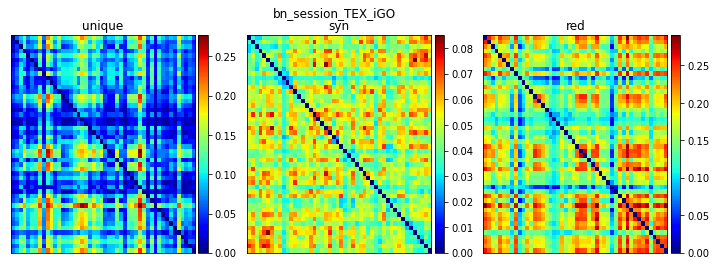

unique 103776 103776
syn 51888 51888
red 51888 51888
0.31399117286480055
0.09926437563799151
0.34712147259147175


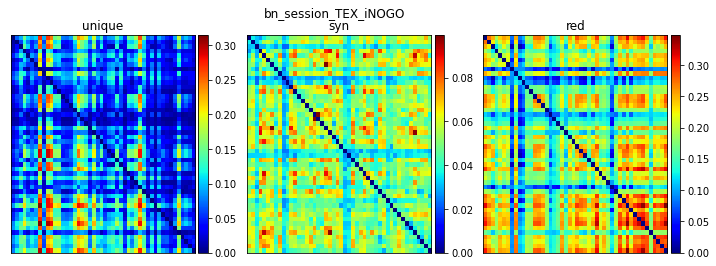

unique 103776 103776
syn 51888 51888
red 51888 51888
0.2611862316594155
0.07534808042069181
0.29936174028712115


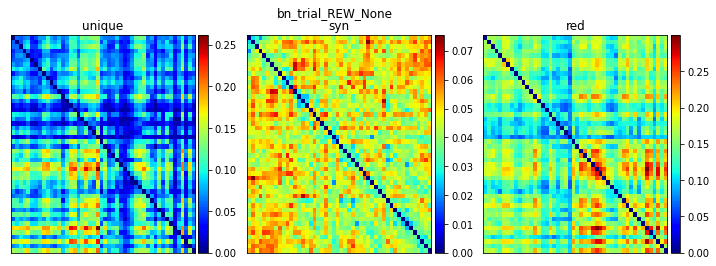

unique 103776 103776
syn 51888 51888
red 51888 51888
0.21409523198163083
0.06851830722738658
0.2250461670292602


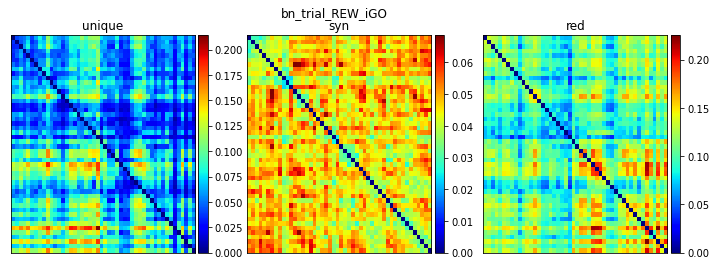

unique 103776 103776
syn 51888 51888
red 51888 51888
0.2644088982781552
0.0812948650228527
0.33085788591171494


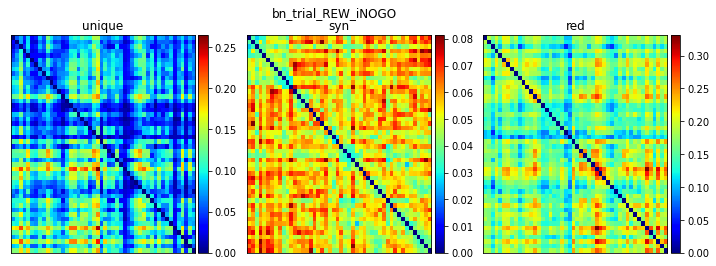

unique 103776 103776
syn 51888 51888
red 51888 51888
0.27538262236966593
0.09609279041096691
0.3778399448577669


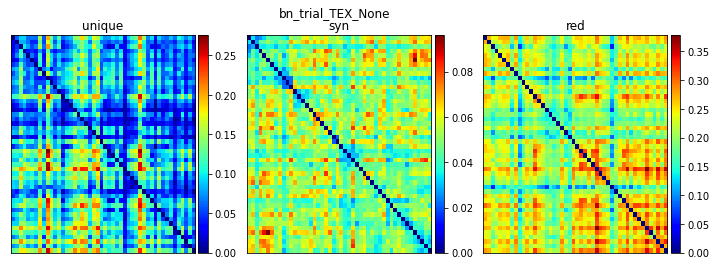

unique 103776 103776
syn 51888 51888
red 51888 51888
0.2778463641109713
0.10350843634944869
0.38155264467734534


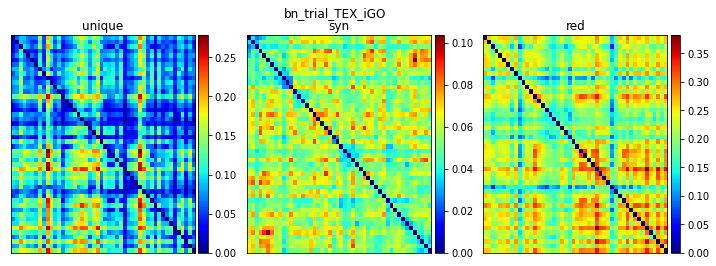

unique 103776 103776
syn 51888 51888
red 51888 51888
0.2832207388375253
0.09819792228853079
0.39992600365035225


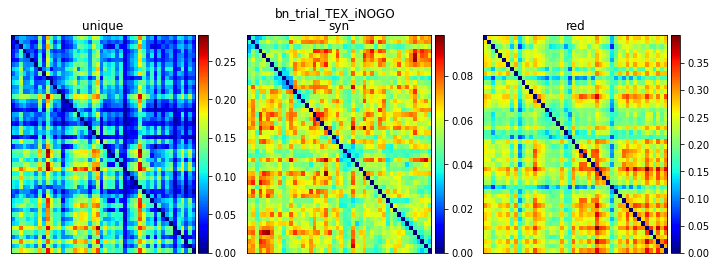

In [22]:
pid_joint.plot_2D_avg(dataDB, pwdAllH5_2, dfSummary, dropChannels=None)

unique 103776 103776
syn 51888 51888
red 51888 51888
0.7403913729673104
0.25173791753562624
0.6333124022514435


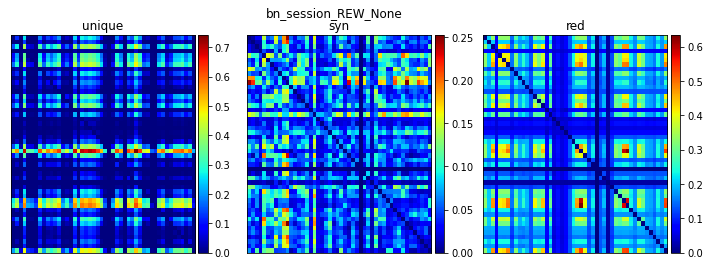

unique 103776 103776
syn 51888 51888
red 51888 51888
0.5770243602890016
0.1631622742351404
0.5286877657618768


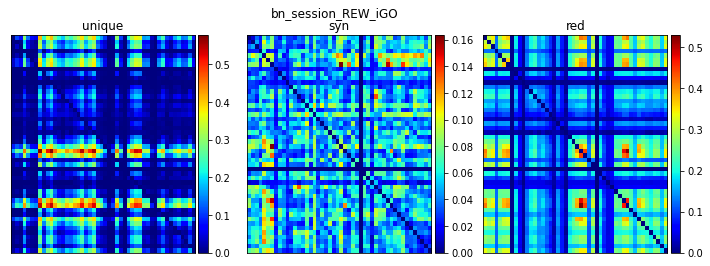

unique 103776 103776
syn 51888 51888
red 51888 51888
0.4446610367725669
0.129782522154122
0.44645104122111867


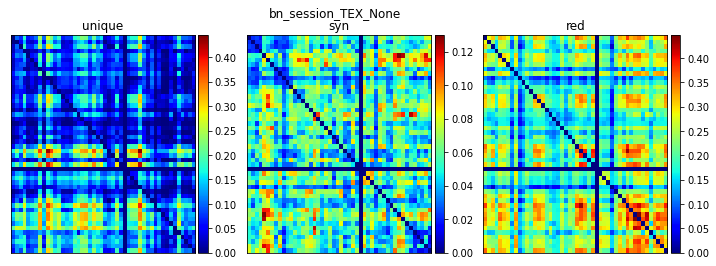

unique 103776 103776
syn 51888 51888
red 51888 51888
0.4549394736846653
0.13658265947977144
0.47361745606561895


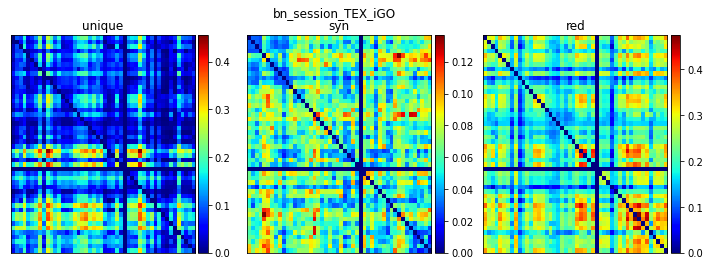

unique 103776 103776
syn 51888 51888
red 51888 51888
0.4995916624603006
0.1575854139624383
0.5378535285470545


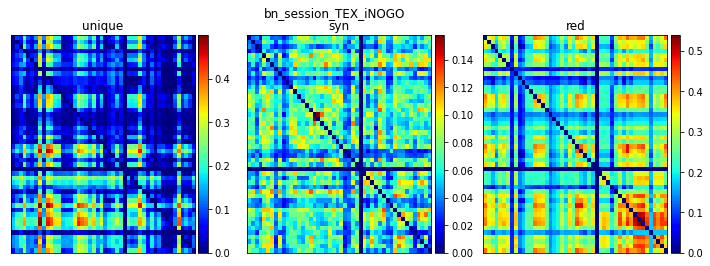

unique 103776 103776
syn 51888 51888
red 51888 51888
0.5253387755317518
0.1459148008099942
0.5306017304418347


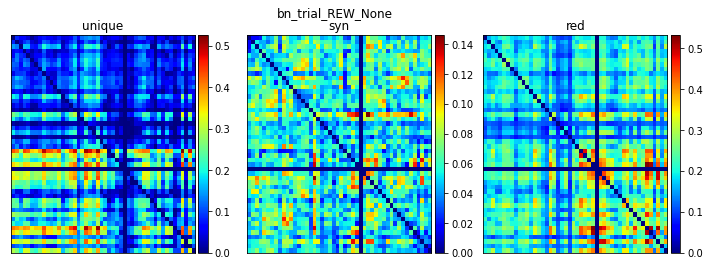

unique 103776 103776
syn 51888 51888
red 51888 51888
0.3964354309948049
0.12410030099837657
0.41076243401955154


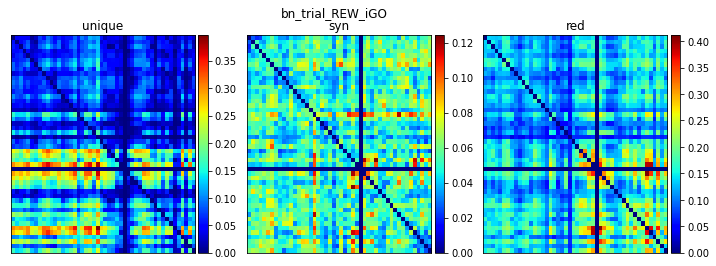

unique 103776 103776
syn 51888 51888
red 51888 51888
0.5144414187267394
0.15257349565549716
0.5481780149050977


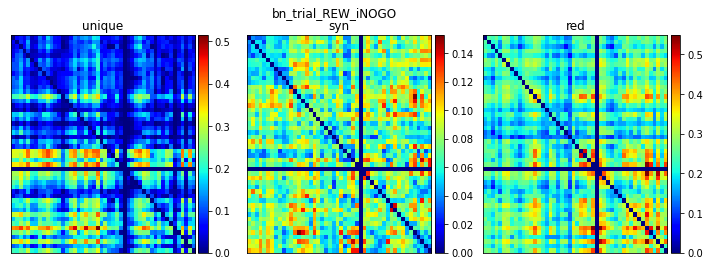

unique 103776 103776
syn 51888 51888
red 51888 51888
0.5234825394452847
0.14298259858793516
0.5982875051657601


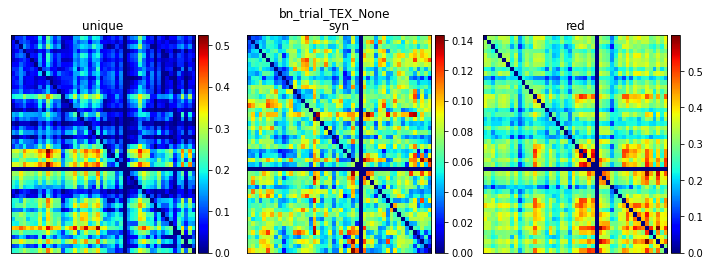

unique 103776 103776
syn 51888 51888
red 51888 51888
0.527349238607792
0.15224899526414282
0.6167876260575006


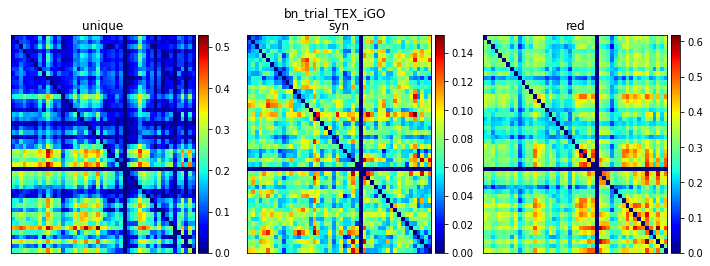

unique 103776 103776
syn 51888 51888
red 51888 51888
0.5526031133603461
0.15748765196573017
0.6313617455334583


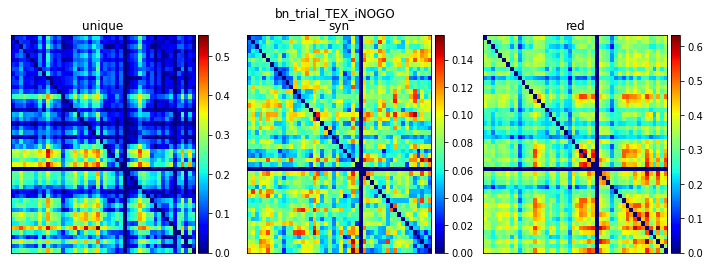

In [24]:
pid_joint.plot_2D_bytarget(dataDB, pwdAllH5_2, dfSummary, 'Rt', dropChannels=None)

## Sanity check if PID matches pre-computed

In [17]:
for datatype in ['bn_session', 'bn_trial']:
    for intervKey in intervDict.keys():
        for trialType in [None, 'iGO', 'iNOGO']:
            for mousename in ['mvg_4']: #sorted(dataDB.mice):
                print(datatype, intervKey, trialType, mousename)
                
                channelNames = dataDB.get_channel_labels(mousename)
                dataLst = dataDB.get_neuro_data({'mousename': mousename}, datatype=datatype,
                                                trialType=trialType,
                                                zscoreDim='rs', cropTime=intervDict[intervKey])

                display(pid.pid(dataLst, mc, channelNames, ['S1_bf', 'VPL'], ['LGP'], nPerm=100, nBin=4))
                break
            break
        break
    break

bn_session TEX None mvg_4
(6540, 48)


,S1,S2,T,PID,p,effSize,muTrue,muRand
0,S1_bf,VPL,LGP,U1,0.71,-0.729158,0.000317,0.000672
1,S1_bf,VPL,LGP,U2,0.01,395.001676,0.167724,0.000579
2,S1_bf,VPL,LGP,red,0.01,1374.538908,0.225553,0.000323
3,S1_bf,VPL,LGP,syn,0.01,81.049234,0.072034,0.003206
